In [73]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import h5py
import os
import os.path as osp
from tqdm.notebook import tqdm

# === USER INPUTS ===
backend_dir =  osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/")  # <- replace with your emcee backend file
[f for f in os.listdir(backend_dir) if 'run' in f]

['full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse).h5',
 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run.h5',
 'full_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTFalse_covTrue.h5',
 'full_run_Cs_BCTrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run_Cs_BCFalse_F1p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run_Cs_ATrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse.h5',
 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covTrue.h5',
 'full_run_AFalse_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run_ATrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5',
 'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue.h5']

Loaded backend with 96 walkers and 4485 steps.
Autocorrelation times (steps): [ 43.58547945 293.02976857 298.9470089  136.34685184 258.87941787
 295.94572618 320.99792501]


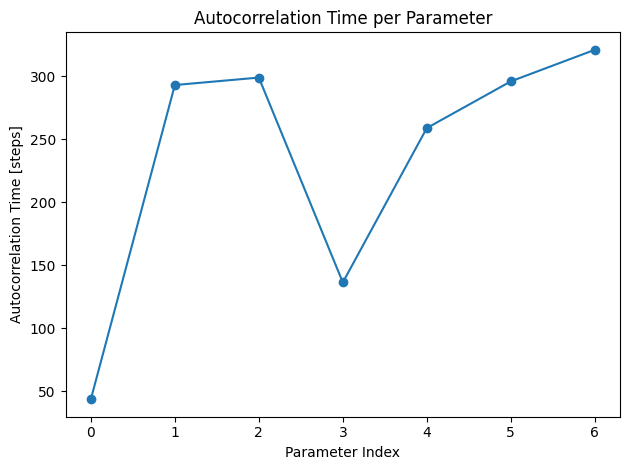

In [86]:
backend_file = backend_dir+'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'
# backend_file = backend_dir+'full_run_Cs_BCTrue_F1p0_DTrue_FlatFalse_SpecTrue_dTFalse_covFalse.h5'
# backend_file = backend_dir+'full_run_Cs_ATrue_F2p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'

# backend_file = backend_dir+'full_run_AFalse_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5'

# backend_file = backend_dir+'full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTFalse_covTrue.h5'
# backend_file = backend_dir+'full_run.h5'
discard = 0  # number of burn-in steps to discard
thin = 10      # thinning factor for chains
flat = True    # whether to flatten the chain
max_autocorr_steps = 100  # how far to try computing autocorr
# ====================

# Load the backend
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
n_steps, n_walkers, n_dim = backend.get_chain().shape
print(f"Loaded backend with {n_walkers} walkers and {n_steps} steps.")

# Check if there's enough data
if n_steps < 2 * discard:
    raise RuntimeError("Too few samples to discard burn-in.")

# Compute autocorrelation time
try:
    tau = backend.get_autocorr_time(tol=0, discard=discard)
    print("Autocorrelation times (steps):", tau)
except emcee.autocorr.AutocorrError:
    print("WARNING: Autocorrelation time could not be reliably estimated. Showing partial results.")
    tau = None

# Plot autocorrelation estimate per parameter (if possible)
if tau is not None:
    fig, ax = plt.subplots()
    ax.plot(tau, "o-")
    ax.set_xlabel("Parameter Index")
    ax.set_ylabel("Autocorrelation Time [steps]")
    ax.set_title("Autocorrelation Time per Parameter")
    plt.tight_layout()
    plt.show()

In [87]:
acceptance_fraction = backend.accepted / backend.iteration
# acceptance_fraction
backend.accepted

array([218., 161., 176., 131., 179., 186., 198., 171., 221., 162., 139.,
       144., 220., 146., 193., 175., 127., 185., 146., 178., 201., 156.,
       156., 176., 191., 115., 125., 231., 221., 149., 149., 150., 229.,
       246., 232., 183., 190., 222., 197., 158., 245., 169., 160., 166.,
       161., 227., 159., 183., 233., 152., 230., 182., 250., 207., 173.,
       207., 196., 162., 181., 175., 188., 188., 136., 248., 152., 261.,
       172., 271., 172., 160., 164., 180., 264., 191., 176., 238., 276.,
       234., 180., 176., 233., 268., 242., 136., 220., 122., 163., 271.,
       172., 171., 168., 286., 173., 151., 167., 151.])

Loaded backend with 96 walkers, 4485 steps, 7 dimensions.


  0%|          | 0/448 [00:00<?, ?it/s]

/home/cj1223/.conda/envs/torch-env/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


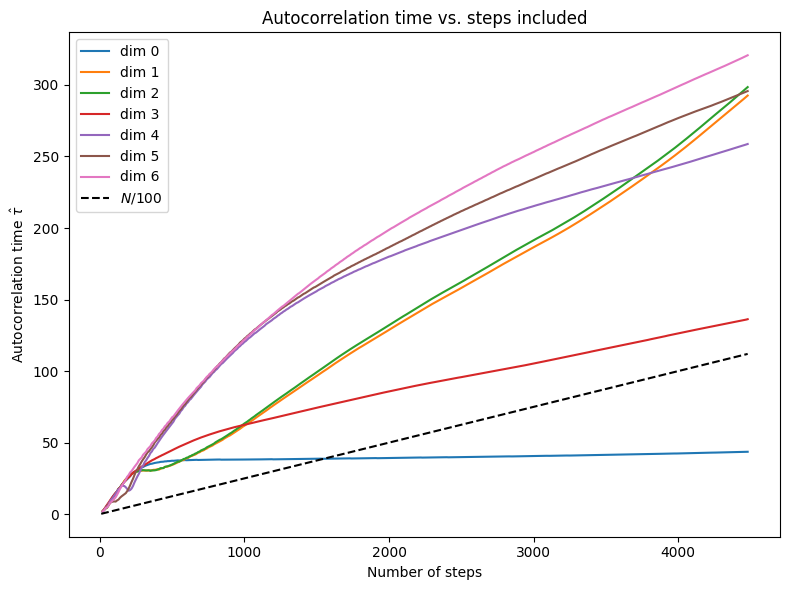

In [88]:
discard = 0
thin = 1
step_stride = 10
min_steps = 10

# ====================

# Load backend and chain
backend = emcee.backends.HDFBackend(backend_file, read_only=True)
full_chain = backend.get_chain(discard=discard, thin=thin)
n_steps, n_walkers, n_dim = full_chain.shape
max_steps = n_steps+100
print(f"Loaded backend with {n_walkers} walkers, {n_steps} steps, {n_dim} dimensions.")

# Limit the max_steps to what's available
max_steps = min(max_steps, n_steps)

# Storage
all_taus = []
step_list = []

# Loop over truncated chains
for n in tqdm( range(min_steps, max_steps + 1, step_stride) ):
    truncated = full_chain[:n]  # shape (n, n_walkers, n_dim)
    try:
        tau = emcee.autocorr.integrated_time(truncated, tol=0)
        all_taus.append(tau)
        step_list.append(n)
    except emcee.autocorr.AutocorrError:
        print(f"Step {n}: autocorr failed")
        continue

# Convert to arrays
all_taus = np.array(all_taus)  # shape (num_points, ndim)
step_list = np.array(step_list)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_dim):
    ax.plot(step_list, all_taus[:, i], label=f"dim {i}")
ax.plot(step_list, step_list / 40, "--k", label=r"$N/100$")

ax.set_xlabel("Number of steps")
ax.set_ylabel(r"Autocorrelation time $\hat{\tau}$")
ax.set_title("Autocorrelation time vs. steps included")
ax.legend()
plt.tight_layout()
plt.show()


Samples shape: (362976, 7)


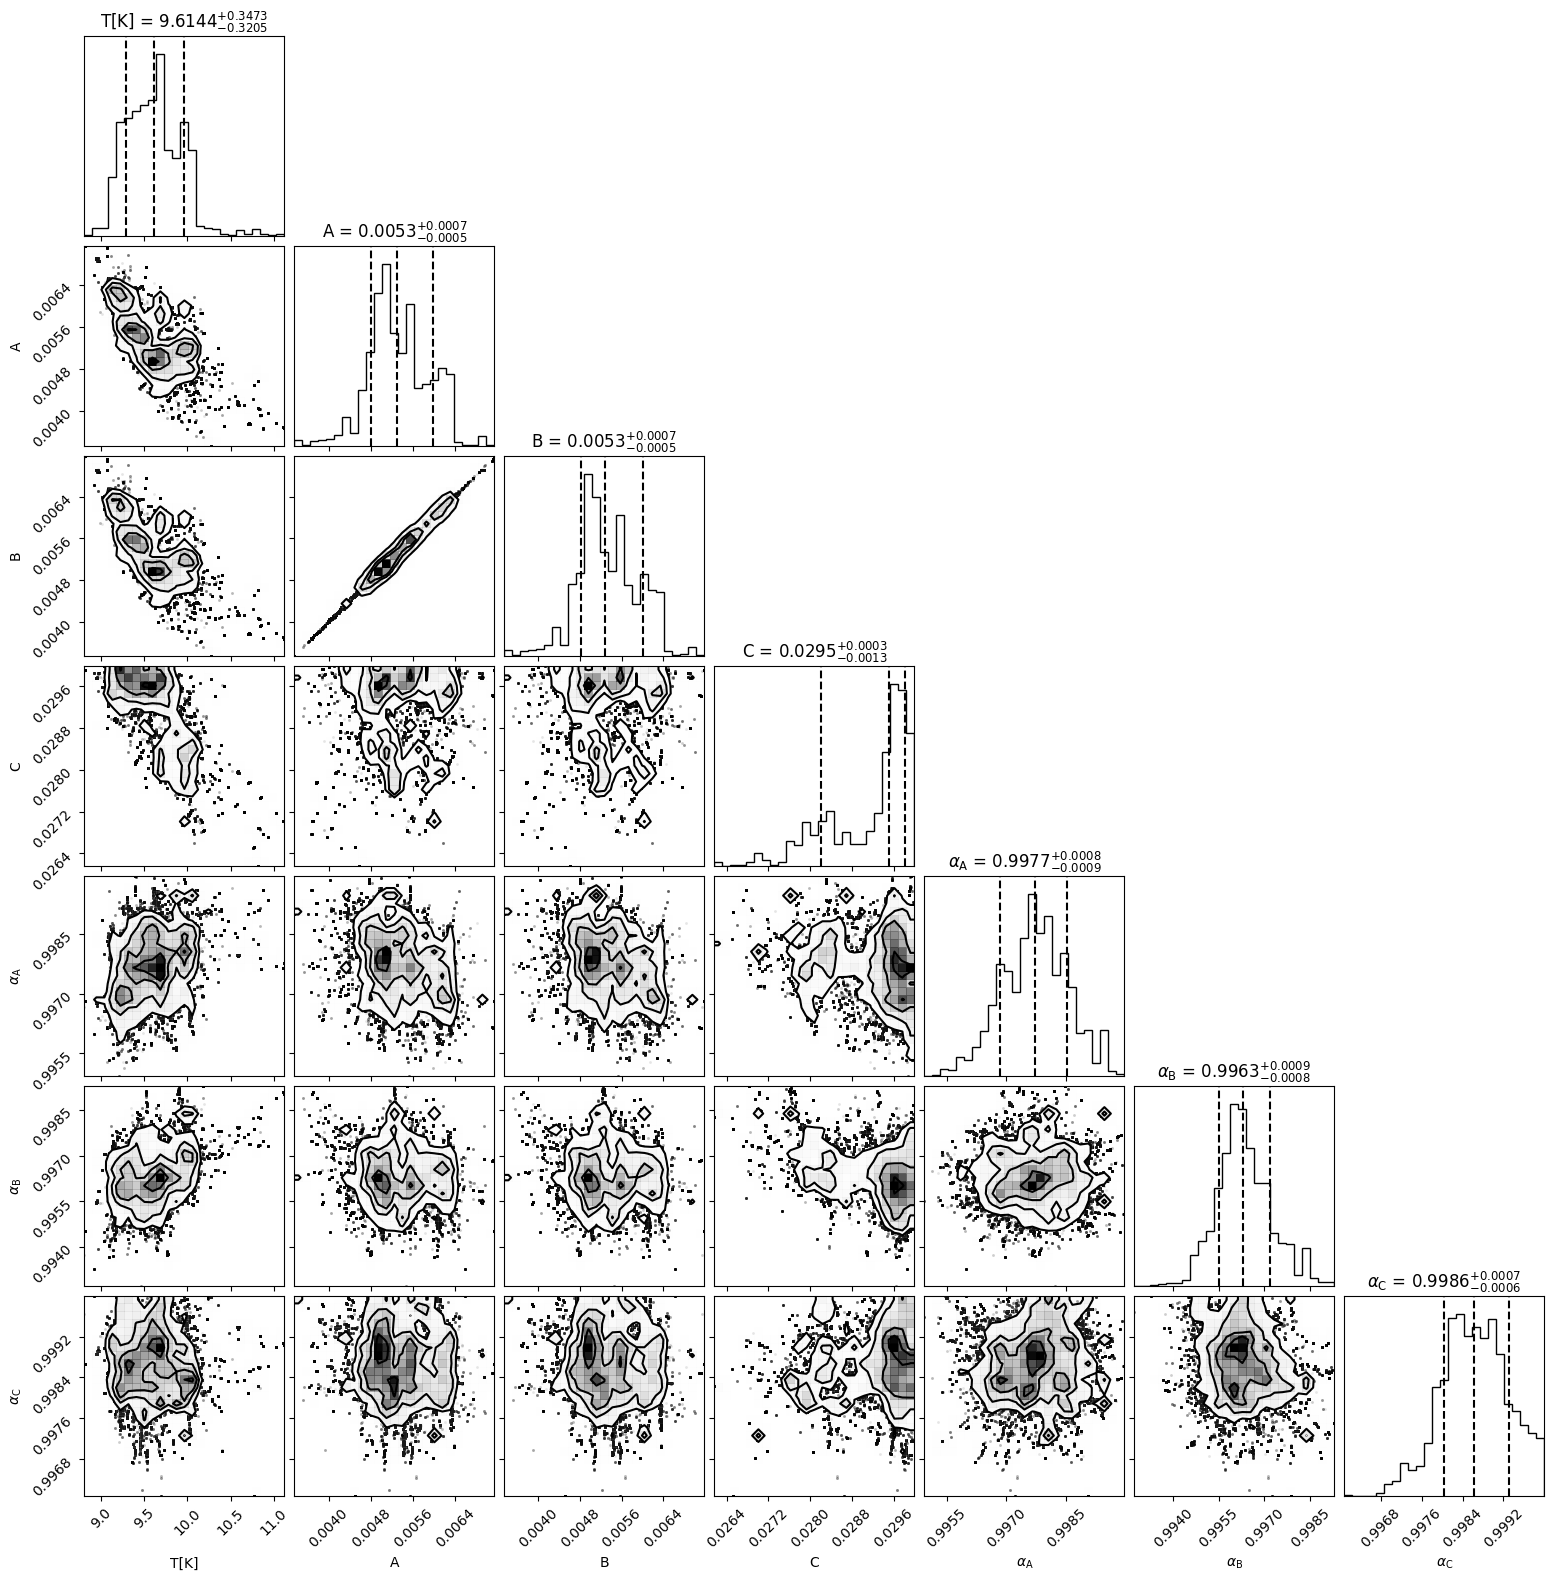

In [89]:
if n_dim == 5:
    # Extract samples
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)
    
    print(f"Samples shape: {samples.shape}")
    
    labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{AB}}$', r'$\mathrm{C}$', r'$\mathrm{AB}$', 'T[K]']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels[::-1],
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels)
    )
    plt.show()


if n_dim == 7:
    # Extract samples
    thin = 1
    discard = int( 3*np.mean(all_taus[-1, :]) )
    samples = backend.get_chain(discard=discard, thin=thin, flat=flat)
    log_prob = backend.get_log_prob(discard=discard, thin=thin, flat=flat)
    
    print(f"Samples shape: {samples.shape}")
    
    labels = [r'$\alpha_{\mathrm{C}}$', r'$\alpha_{\mathrm{B}}$', r'$\alpha_{\mathrm{A}}$', r'$\mathrm{C}$', r'$\mathrm{B}$', r'$\mathrm{A}$', 'T[K]']
    # Corner plot
    fig = corner.corner(
        samples,
        labels=labels[::-1],
        bins = 25,
        show_titles=True,
        smooth = 0.6,
        quantiles=[0.16, 0.5, 0.84],
        title_fmt=".4f",
        range = [0.99999]*len(labels)
    )
    plt.show()


In [98]:
A = 0.05
B = 0.0053
(1/(1/A+1/B) ) / B

0.9041591320072333

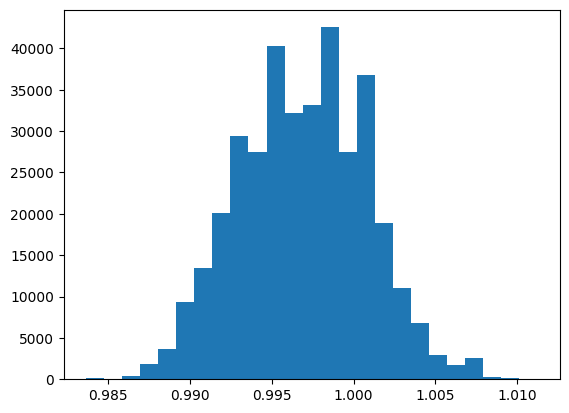

In [99]:
plt.hist(samples[:,1]/samples[:,2], bins = 25);

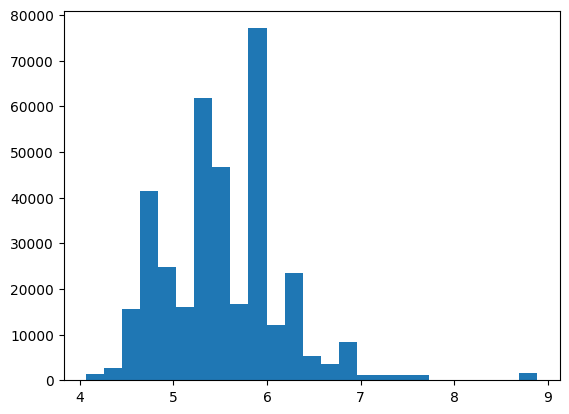

In [100]:
plt.hist(samples[:,3]/samples[:,1], bins = 25);

In [101]:
# np.savetxt(osp.expanduser("~/../../scratch/gpfs/cj1223/DIB/emcee_orig_2276.txt"), samples)
errs = h5py.File('jackknife_dib.h5', "r")
errs['cov']

<HDF5 dataset "cov": shape (143, 143, 4), type "<f8">

In [102]:

# === USER INPUTS ===

savetest = emcee.backends.HDFBackend(backend_file, read_only=True)
savetest, backend_file

(<emcee.backends.hdf.HDFBackend at 0x15247a33f640>,
 '/home/cj1223/../../scratch/gpfs/cj1223/DIB/full_run_ATrue_F5p0_DTrue_FlatFalse_SpecTrue_dTTrue_covFalse.h5')

In [33]:
DIB_15272 = h5py.File('new_errs/res_dib_15272.h5', "r")
data_wavelength = DIB_15272['wav'][:]
data_flux = DIB_15272['mean'][:][:,0]
data_flux_dT = DIB_15272['mean'][:][:,1]

noise_std = 2*fudge*np.sqrt(DIB_15272['var'][:][:,0])
noise_std_dT = fudge*np.sqrt(DIB_15272['var'][:][:,1])

True

In [34]:
savetest.get_blobs()

array([[[ -10.54502665,   -0.82438407, -205.8200388 ],
        [ -10.37038346,   -0.80213223, -227.4198411 ],
        [ -10.27880305,   -0.79890967, -209.03188465],
        ...,
        [ -11.10292074,   -0.85685803, -229.94213543],
        [ -11.05459404,   -0.82620013, -205.46327121],
        [ -10.56989436,   -0.81807624, -227.67329141]],

       [[ -10.54502665,   -0.82438407, -205.8200388 ],
        [ -10.37038346,   -0.80213223, -227.4198411 ],
        [ -10.38757289,   -0.80647818, -216.23124086],
        ...,
        [ -11.10125813,   -0.85237308, -227.70320252],
        [ -11.05459404,   -0.82620013, -205.46327121],
        [ -10.56989436,   -0.81807624, -227.67329141]],

       [[ -10.54502665,   -0.82438407, -205.8200388 ],
        [ -10.37018052,   -0.80274547, -229.64091296],
        [ -10.38757289,   -0.80647818, -216.23124086],
        ...,
        [ -11.10125813,   -0.85237308, -227.70320252],
        [ -11.08257365,   -0.84255846, -215.38063872],
        [ -10.12587086

In [35]:
savetest.get_log_prob()

array([[-12738.88052527, -12235.14521988, -11941.38201698, ...,
        -13124.51803696, -13519.13594339, -12488.5052286 ],
       [-12738.88052527, -12235.14521988, -11794.79379528, ...,
        -13112.08259596, -13519.13594339, -12488.5052286 ],
       [-12738.88052527, -12233.66057252, -11794.79379528, ...,
        -13112.08259596, -13227.70850929, -11807.03833271],
       ...,
       [  -656.04336131,   -661.40437837,   -661.86168358, ...,
          -654.72230539,   -657.72085515,   -655.75236059],
       [  -656.04336131,   -661.40437837,   -661.86168358, ...,
          -654.72230539,   -657.72085515,   -655.75236059],
       [  -656.04336131,   -661.40437837,   -661.86168358, ...,
          -654.72230539,   -657.72085515,   -655.75236059]])

In [36]:
np.std(savetest.get_log_prob(), axis = 0)

array([1141.06935419, 1176.77540092, 1186.29106993, 1150.95272649,
       1205.89383198, 1228.54207472, 1049.26044415, 1161.64259159,
       1165.21065077, 1153.4092039 , 1164.48011251, 1210.69326035,
        967.23216938, 1173.59017455, 1103.82003281, 1214.96304291,
       1101.62080837, 1418.83814189,  973.00482055, 1358.19145492,
       1124.85369302, 1236.32241189, 1158.76882465, 1349.82558571,
       1129.04798662, 1184.1738741 , 1105.57639433, 1095.26323785,
       1296.09204737, 1232.97451149, 1364.55107765, 1214.06376923,
       1317.32267829,  992.37060148, 1273.24562265, 1235.6750085 ,
       1288.25476594, 1302.59544932,  955.1951707 , 1200.97887588,
       1372.7453079 , 1294.54927356, 1216.3778788 , 1309.66527773,
        874.41675975, 1198.02554472, 1270.90368862, 1171.48314522,
       1218.91896061, 1243.96434929, 1207.09257272, 1201.34675534,
       1172.29076551, 1230.10699777, 1239.34051629, 1263.05492617,
       1170.35474377,  993.1040536 , 1096.90041572, 1158.76109

In [37]:
savetest.accepted

array([129., 170., 135., 148., 144., 143., 138., 121., 115., 151., 131.,
       100., 125., 139., 131., 126., 137., 130., 132., 116., 149., 129.,
       105., 139., 126., 112., 112., 144., 124., 103., 153., 119., 105.,
       145., 119., 122., 144., 124., 129., 132., 143., 148., 174.,  89.,
       119., 153., 158., 124., 111., 153., 141., 134., 114., 126., 140.,
       137., 127., 134., 120., 124., 148., 139., 134., 138., 107., 126.,
       165., 130., 158., 120., 186., 123., 156., 133., 142., 125., 116.,
       105., 121., 116., 115., 152., 146., 125., 126., 148., 106., 134.,
       137., 132., 154., 140., 154., 136., 120., 122.])

In [127]:
from multiprocessing import get_context
import subprocess, os, emcee, time, shutil, h5py, argparse
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import os.path as osp
from pathlib import Path
from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.signal import convolve

# Constants
PGO_TEMPLATE = "asym_top_15272_Cs.pgo"

TEMP_DIR = f"pgo_temppy"
os.makedirs(TEMP_DIR, exist_ok=True)
shutil.rmtree(TEMP_DIR, ignore_errors=False, onerror=None)
os.makedirs(TEMP_DIR, exist_ok=True)

def filename_base(T, A_base, B_base, C_base, frac_A, frac_B, frac_C):
    return f"T{T:.3f}_A{A_base:.7f}_B{B_base:.7f}_C{C_base:.7f}_FA{frac_A:.5f}_FB{frac_B:.5f}_FC{frac_C:.5f}"

def generate_pgopher_input(T, A_base, B_base, C_base, frac_A, frac_B, frac_C):
    A_g, B_g, C_g = A_base, B_base, C_base
    A_e, B_e, C_e = A_base * frac_A, B_base * frac_B, C_base * frac_C

    base = filename_base(T, A_base, B_base, C_base, frac_A, frac_B, frac_C)
    pgo_file = os.path.join(TEMP_DIR, f"temp_{base}.pgo")
    spec_txt = os.path.join(TEMP_DIR, f"spec_{base}.txt")

    awk_script = f'''
    awk -v temp="{T}" \\
        -v A_ground="{A_g}" -v B_ground="{B_g}" -v C_ground="{C_g}" \\
        -v A_excited="{A_e}" -v B_excited="{B_e}" -v C_excited="{C_e}" '
    BEGIN {{ inside_ground = 0; inside_excited = 0; }}
    /<Parameter Name="Temperature" Value="/ {{
        sub(/Value="[0-9.eE+-]+"/, "Value=\\"" temp "\\"")
    }}
    /<AsymmetricManifold Name="Ground"/ {{ inside_ground = 1 }}
    /<AsymmetricManifold Name="Excited"/ {{ inside_excited = 1 }}
    /<\/AsymmetricManifold>/ {{ inside_ground = 0; inside_excited = 0 }}
    inside_ground && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_ground "\\"") }}
    inside_ground && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_ground "\\"") }}
    inside_ground && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_ground "\\"") }}
    inside_excited && /<Parameter Name="A" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" A_excited "\\"") }}
    inside_excited && /<Parameter Name="B" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" B_excited "\\"") }}
    inside_excited && /<Parameter Name="C" Value="/ {{ sub(/Value="[0-9.eE+-]+"/, "Value=\\"" C_excited "\\"") }}
    {{ print }}
    ' {PGO_TEMPLATE} > {pgo_file}
    '''

    subprocess.run(awk_script, shell=True, check=True, executable="/bin/bash")
    subprocess.run(["./pgo", "--plot", pgo_file, spec_txt], check=True, stdout=subprocess.DEVNULL)
    return spec_txt, base

def convolve_pgopher_spectrum(spectrum_file, center_wav, lsf_key='LCO+APO', dlam=0.01, window=8):
    """
    Convolve PGOPHER output using LSF evaluated on a regular wavelength grid.

    Parameters:
        spectrum_file (str): PGOPHER output file with [wavenumber (1/cm), flux].
        center_wav (float): Central wavelength for the LSF (Å).
        lsf_key (str): Instrument profile selector (placeholder).
        dlam (float): Spacing (Å) for the regular wavelength grid.
        window (float): Half-width (Å) of the wavelength region to define the regular grid.

    Returns:
        wav_lsf (np.ndarray): Wavelength grid used for final output.
        flux_on_lsf_grid (np.ndarray): Flux convolved and resampled to wav_lsf.
        lsf_kernel (np.ndarray): LSF evaluated on regular grid.
        wav_pgo (np.ndarray): Original PGOPHER wavelength grid.
        convolved_flux (np.ndarray): Full-resolution convolved flux (on regular grid).
    """
    # === Load PGOPHER spectrum ===
    inv_cm, flux = np.loadtxt(spectrum_file).T
    wav_pgo = 1e8 / inv_cm

    wavc = 15272.27178113337
    # === Define regular wavelength grid around center ===
    wav_reg = np.arange(wavc - window, wavc + window, dlam)

    # === Interpolate PGOPHER flux onto this regular grid ===
    flux_interp = interp1d(wav_pgo, flux, bounds_error=False, fill_value=0.0)
    flux_reg = flux_interp(wav_reg)

    # === Construct LSF kernel on regular grid ===
    sig1 = 0.3
    sig2 = 1.85 * sig1
    sig3 = 9.5 * sig1
    f1 = 0.895
    f2 = 0.1
    c0 = 1.3e-3

    rel_grid = wav_reg - wavc  # Center the kernel
    p1 = 1/np.sqrt(2*np.pi*sig1**2)*np.exp( - rel_grid**2 / (2 * sig1**2) )
    p2 = 1/np.sqrt(2*np.pi*sig2**2)*np.exp( - rel_grid**2 / (2 * sig2**2) )
    p3 = 1/np.sqrt(2*np.pi*sig3**2)*np.exp( - rel_grid**2 / (2 * sig3**2) )

    lsf_kernel = f1 * p1 + f2 * p2 + (1 - f1 - f2) * p3 + c0
    lsf_kernel /= np.sum(lsf_kernel)

    # === Convolve on regular grid ===
    convolved_flux = convolve(flux_reg, lsf_kernel, mode='same')

    # === Interpolate back to original PGOPHER (or LSF) grid ===
    out_interp = interp1d(wav_reg, convolved_flux, bounds_error=False, fill_value=0.0)

    lsf_file = f'LSFs/lsf_15272.h5'
    # Load LSF and its wavelength grid
    with h5py.File(lsf_file, 'r') as f:
        wav_load = f['wav'][:]
      # Or replace with another grid if desired
    flux_on_lsf_grid = out_interp(wav_load)

    return wav_load, flux_on_lsf_grid

fudge = 1
DIB_15272 = h5py.File('new_errs/res_dib_15272.h5', "r")
data_wavelength = DIB_15272['wav'][:]
data_flux = DIB_15272['mean'][:][:,0]
data_flux_dT = DIB_15272['mean'][:][:,1]

noise_std = 2*fudge*np.sqrt(DIB_15272['var'][:][:,0])
noise_std_dT = fudge*np.sqrt(DIB_15272['var'][:][:,1])

In [142]:
def sample_and_stack_posterior(
    samples, N, data_flux, data_flux_dT, data_wavelength,
    noise_std, noise_std_dT, fit_dT = False, central_wav=15272.27
):
    
    """
    Sample the posterior N times from the emcee backend and return stacked data+model arrays.

    Returns:
        model_flux_stack: [N, len(wavelength)] convolved model spectra
        model_flux_dT_stack: [N, len(wavelength)] convolved dT model spectra
        data_flux_stack: [N, len(wavelength)] observed spectra (broadcasted)
        data_flux_dT_stack: [N, len(wavelength)] observed dT spectra (broadcasted)
        scalars_stack: [N, 3] best-fit scalar coefficients per sample
    """
    # Extract flattened samples
    print(f"Sampling {N} draws from {len(samples)} posterior points")

    # Randomly choose N indices
    rng = np.random.default_rng()
    inds = rng.choice(len(samples), size=N, replace=False)
    
    model_flux_stack = []
    model_flux_dT_stack = []
    data_flux_stack = []
    data_flux_dT_stack = []
    scalars_stack = []

    for i in inds:
        params = samples[i]
        T, A, B, C, frac_A, frac_B, frac_C = params
        # Re-generate model to stack
        spec_txt, _ = generate_pgopher_input(T, A, B, C, frac_A, frac_B, frac_C)
        _, model_flux = convolve_pgopher_spectrum(spec_txt, central_wav)
        os.remove(spec_txt)

        if fit_dT:
            spec_txt_dT, _ = generate_pgopher_input(T + 0.05, A, B, C, frac_A, frac_B, frac_C)
            _, model_flux_dT = convolve_pgopher_spectrum(spec_txt_dT, central_wav)
            os.remove(spec_txt_dT)
        else:
            model_flux_dT = np.zeros_like(model_flux)

        model_flux_stack.append(model_flux)
        model_flux_dT_stack.append(model_flux_dT)
        data_flux_stack.append(data_flux)
        data_flux_dT_stack.append(data_flux_dT)
        # scalars_stack.append(scalars)

    return (
        np.array(model_flux_stack),
        np.array(model_flux_dT_stack),
        np.array(data_flux_stack),
        np.array(data_flux_dT_stack),
        # np.array(scalars_stack)
    )


In [143]:
thin = 1
discard = int( 5*np.mean(all_taus[-1, :]) )
samples = backend.get_chain(discard=discard, thin=thin, flat=flat)

m, m_dT, _, _ = sample_and_stack_posterior(samples, 10, data_flux, data_flux_dT, data_wavelength, noise_std, noise_std_dT)

Sampling 10 draws from 320064 posterior points


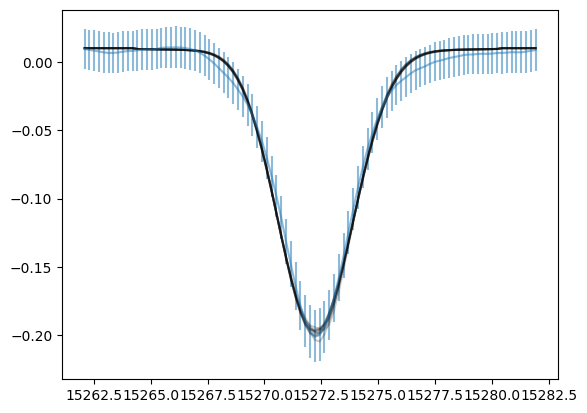

In [146]:
plt.errorbar(data_wavelength, data_flux, yerr = noise_std, alpha = 0.5)
plt.plot(data_wavelength, -1.15*m.T+0.01, 'k-', alpha = 0.2)
